In [1]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT

Mounted at /content/drive


In [2]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .config("spark.sql.broadcastTimeout", "36000")\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

In [3]:
sc = spark.sparkContext

In [4]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from gensim.models import Phrases

import warnings  
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from pyspark.ml.feature import VectorAssembler,CountVectorizer, IDF, Tokenizer
from pyspark.ml.feature import CountVectorizerModel, IDFModel, BucketedRandomProjectionLSHModel
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.clustering import LDA,LocalLDAModel, DistributedLDAModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors,DenseVector
from pyspark.sql.functions import col

from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import isnan, when, count, col, lit, udf, collect_list
from pyspark.sql.functions import pandas_udf
from pyspark.sql.window import Window

from pyspark.sql.types import FloatType

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
#######################################
###!@2 START OF DEFINING INPUT FILES
genomeScoresFile = "/content/drive/MyDrive/Project-Building-a-Movie-Catalog/ml-25m/genome-scores.csv"
genomeTagsFile = "/content/drive/MyDrive/Project-Building-a-Movie-Catalog/ml-25m/genome-tags.csv"
moviesFile = "/content/drive/MyDrive/Project-Building-a-Movie-Catalog/ml-25m/movies.csv"
ratingsFile = "/content/drive/MyDrive/Project-Building-a-Movie-Catalog/ml-25m/ratings.csv"
tagsFile = "/content/drive/MyDrive/Project-Building-a-Movie-Catalog/ml-25m/tags.csv"
###!@2 END OF DEFINING INPUT FILES

In [6]:
stop_words = list(stopwords.words('english'))
stop_words = sc.broadcast(stop_words)
lemmatizer = sc.broadcast(WordNetLemmatizer())
stemmer = sc.broadcast(SnowballStemmer("english"))
excluded_words=['original','jay','bob','pack','base','based','new','york','san','fransisco']
sim_words={'scifi':'sci-fi','sci':'sci-fi','romance':'romantic','violence':'violent'}
similar_words = sc.broadcast(sim_words)
excluded_tags = sc.broadcast(excluded_words)

In [7]:
movies_df = spark.read.csv(moviesFile,header=True)
gen_scores_df = spark.read.csv(genomeScoresFile,header=True)
gen_tags_df = spark.read.csv(genomeTagsFile,header=True)
ratings_df = spark.read.csv(ratingsFile,header=True)
tags_df = spark.read.csv(tagsFile,header=True)

In [8]:
genome_scores_df=spark.read.csv(genomeScoresFile,header='true')
genome_tags_df=spark.read.csv(genomeTagsFile,header='true')
genome_scores_df=genome_scores_df.orderBy(f.col("relevance").desc()).filter(f.col("relevance")>=0.7)
genome_tags_df=genome_tags_df.withColumnRenamed("tagId","gtagId")
genome_df = genome_scores_df.join(genome_tags_df,f.col("tagId")==f.col("gtagId")).drop("gtagId").select("tagId","movieId","tag")

In [9]:
def train_bigram(df):
  """
  Gensim Phraser to train bigram phraser on the corpus
  """
  tagList = [x[0] for x in genome_df.select('tag').collect()]
  tags = [doc.split(" ") for doc in tagList]
  bigram = Phrases(tags, min_count=1, threshold=2)
  return bigram
bigram_model= train_bigram(genome_df)
bigrams_phraser = sc.broadcast(bigram_model)

In [10]:
def text_preprocessing(text):
  """
  Preprocess text
  """
  text = re.sub(r'[^\w\s-]',' ',text)
  words = nltk.word_tokenize(text)
  phraser = bigrams_phraser.value
  words = phraser[words]
  tokens=[]
  lemm = lemmatizer.value
  for word in words:
    if word not in stop_words.value and word not in excluded_tags.value and len(word)>2:
      if word in similar_words.value.keys():
        word = similar_words.value[word]
      tokens.append((lemm.lemmatize(word,"v")))
  return tokens

In [11]:
#to find tag length distribution
def find_tag_len(text):
  """
  Get Length of tags
  """
  text = re.sub(r'[^\w\s-]',' ',text)
  words = nltk.word_tokenize(text)
  phraser = bigrams_phraser.value
  words = phraser[words]
  tokens=[]
  lemm = lemmatizer.value
  for word in words:
    if word not in stop_words.value and word not in excluded_tags.value and len(word)>2:
      if word in similar_words.value.keys():
        word = similar_words.value[word]
      tokens.append((lemm.lemmatize(word,"v")))
  return len(tokens)

In [12]:
#tag length distribution
sample = genome_df.rdd.map(lambda x:(x[0],x[2],find_tag_len(x[2]))).toDF(['userId','tag','length'])
tag_length_dist = sample.groupBy(f.col('length')).agg(f.sum(f.col('length')).alias('count')).select('length','count')
tag_length_dist.show()

+------+------+
|length| count|
+------+------+
|     0|     0|
|     7|   280|
|     5|  2520|
|     1|186516|
|     3| 15369|
|     2| 86288|
|     4|  3804|
+------+------+



In [13]:
#pre-process tags
tokens=genome_df.rdd.map(lambda x:(x[1],text_preprocessing(x[2].lower())))
tokens=tokens.reduceByKey(lambda x,y:x+y)
tokens.cache()
X =tokens.zipWithIndex().map(lambda x:(x[0][0],x[0][1],x[1])).toDF(["movieId","tags",'index'])
X.cache()

DataFrame[movieId: string, tags: array<string>, index: bigint]

In [14]:
X.show(50,truncate=False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
#build tf-idf model
cv = CountVectorizer(inputCol="tags", outputCol="features", vocabSize=5000)
cvmodel = cv.fit(X)
result_tfidf = cvmodel.transform(X)
result_tfidf.cache()
idf = IDF(minDocFreq=3, inputCol="features", outputCol="idf_features")
tf_idf_model = idf.fit(result_tfidf)
tf=tf_idf_model.transform(result_tfidf)

In [16]:
tf.select('movieId','features').show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|movieId|features                                                                                                                                                                                                                                                                                           

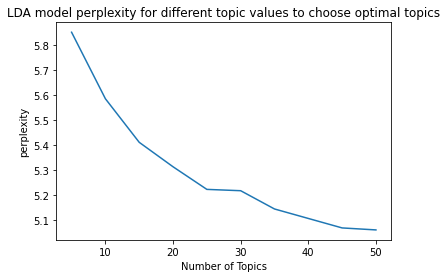

In [17]:
models=[]
perplexity_scores=[]
for i in range(5,51,5):
  num_topics = i
  lda = LDA(k=num_topics, maxIter=100,featuresCol='idf_features',seed=10)
  model = lda.fit(tf)
  models.append(model)
  lp = model.logPerplexity(tf)
  perplexity_scores.append(lp)
x=list(range(5,51,5))
plt.plot(x,perplexity_scores)
plt.title("LDA model perplexity for different topic values to choose optimal topics")
plt.xlabel('Number of Topics')
plt.ylabel('perplexity')
plt.show()

In [18]:
#k=30
vocab = cvmodel.vocabulary
topics = models[5].describeTopics()   
topics_rdd = topics.rdd.map(lambda row: row['termIndices']).map(lambda idx_list: [vocab[idx] for idx in idx_list]).zipWithIndex()
columns = ["topics","topicId"]
topics_df = spark.createDataFrame(data=topics_rdd, schema = columns)
print(topics_df.show(30,truncate=False))

+---------------------------------------------------------------------------------------------------------------------+-------+
|topics                                                                                                               |topicId|
+---------------------------------------------------------------------------------------------------------------------+-------+
|[funny, splatter, silly, gory, blood, fun, comedy, goofy, horror, gore]                                              |0      |
|[spy, espionage, secrets, series, secret_service, assassination, surveillance, 007, assassin, conspiracy]            |1      |
|[fantasy, animation, kid, family, children, cartoon, animate, computer, animals, cute]                               |2      |
|[new_york, french, france, paris, city, prostitution, homeless, light, rome, finnish]                                |3      |
|[comedy, funny, cult, off-beat, satire, humorous, humor, satirical, absurd, hilarious]                 

In [19]:
#apply lda model and join with ratings df
def get_df(model):
  lda_features_df = model.transform(tf)
  lda_features_df = lda_features_df.withColumnRenamed("movieId","cMovieId")
  ratings = ratings_df.groupby("movieId").agg(f.mean("rating").alias("rating")).withColumnRenamed("movieId","mId")
  clusters = lda_features_df.join(movies_df,f.col("movieId")==f.col("cMovieId"),how="left").select("movieId","title","genres","topicDistribution")
  clusters = clusters.join(ratings,f.col("movieId")==f.col("mId"),how="left").select("movieId","title","genres","rating","topicDistribution")
  vecAssembler = VectorAssembler(inputCols=["topicDistribution"], outputCol="values")
  norm_udf = f.udf(lambda v: float((v.norm(2))), FloatType())
  df = vecAssembler.transform(clusters).withColumn("norm",norm_udf('values')).drop('topicDistribution')
  df.cache()
  return lda_features_df,df

In [20]:
lda_features_df,movies_df = get_df(models[5])
brp = BucketedRandomProjectionLSH(inputCol="values", outputCol="hashes", bucketLength=2.0,
                                  numHashTables=1)
brp_model = brp.fit(movies_df)
df = brp_model.transform(movies_df)

In [21]:
vecAssembler = VectorAssembler(inputCols=["topicDistribution"], outputCol="values")

In [22]:
#build similar words dataframe
def get_semantically_sim(word):
  sim=list()
  syn = wordnet.synsets(word)
  if syn:
    for x in syn:
      for y in x.hypernyms():
        for z in y.hyponyms():
            sim.extend(z.lemma_names())
      for l in x.lemmas():
        sim.append(l.name())
  return list(set(sim))
word_mappings = []
for word in vocab:
  word_mappings.append((word,get_semantically_sim(word)))
word_synonyms_df = spark.createDataFrame(data=word_mappings, schema = ["word","synonyms"])

In [23]:
def query_preprocessing(text,movies_df):
  """
  Checks if the given query is a substring of a movie name, else 
  preprocess by finding similar words to the search in vocabulary.
  """
  words = text.split()
  tokens=[]
  for word in words:
    if word not in vocab:
      x = word_synonyms_df.filter(f.array_contains(word_synonyms_df.synonyms,word))
      if not x.rdd.isEmpty():
        tokens.append(x.first().word)
      else:
        word = word_synonyms_df.select('word',f.levenshtein(f.lit(word),f.col('word')).alias('score')).orderBy(f.col('score')).first().word
        tokens.append((word))
    else:
      tokens.append(word)
  return ' '.join(x for x in tokens)

In [24]:
def get_lda_features(cv_model,tfidf_model,lda_model,lda_features_df,movies_df,text,id=-1):
  """
  Get Lda features for the given text or movie id
  """
  if id!=-1:
    topics = lda_features_df.filter(f.col("cMovieId")==id)
    if not topics.rdd.isEmpty():
      return topics
  text=text.strip()
  search_tag=text
  if text:
    search_tag=''
    text=' '.join(x for x in text_preprocessing(text))
    search_tag = query_preprocessing(text,movies_df)
  search_tag = search_tag.strip() 
  if not search_tag: 
    search_tag = vocab[np.random.randint(len(vocab), size=1)[0]]
  search_tag=text_preprocessing(search_tag)
  tags_df = [(search_tag,0)]
  tag_df=spark.createDataFrame(data=tags_df, schema = ["tags","index"])
  cv_features_df = cv_model.transform(tag_df)
  tf_idf_df = tfidf_model.transform(cv_features_df)
  features = lda_model.transform(tf_idf_df)
  return features

def get_similar_movies(cv_model,tfidf_model,lda_model,lsh_model,lda_features_df,movies_df,text,id=-1,n=10):
  """
   Get Similar movies for the given text or movie id
  """
  features_df = get_lda_features(cv_model,tfidf_model,lda_model,lda_features_df,movies_df,text,id)
  features_df = vecAssembler.transform(features_df) 
  vm = (Vectors.dense(features_df.take(1)[0]['values']))
  return lsh_model.approxNearestNeighbors(movies_df, vm, n).orderBy(f.col('distCol'),f.col('rating').desc()).select("title","genres","rating")

In [25]:
def get_topics(text,id=-1):
  features= get_lda_features(cvmodel,tf_idf_model,models[5],lda_features_df,movies_df,text,id).select('topicDistribution').collect()
  for i in range(len(features[0].topicDistribution)):
    print("topic {}: {}".format(i,features[0].topicDistribution[i]))

In [26]:
#Ice age
result = lda_features_df.filter(f.col("cMovieId")==5218).select('topicDistribution').collect()
for i in range(len(result[0].topicDistribution)):
  print("topic {}: {}".format(i,result[0].topicDistribution[i]))

topic 0: 0.00027862028961146777
topic 1: 0.00023550685902713628
topic 2: 0.79111815909905
topic 3: 0.00023884717377772513
topic 4: 0.025668845450071653
topic 5: 0.0003377540550878857
topic 6: 0.00021795573815935844
topic 7: 0.0002417330724309862
topic 8: 0.00026169346062339524
topic 9: 0.00022717560479669862
topic 10: 0.028650301465652443
topic 11: 0.0002597416730895724
topic 12: 0.0002676045251800459
topic 13: 0.00023158549101511924
topic 14: 0.00023597960512315112
topic 15: 0.14779569098487372
topic 16: 0.0002855186004637902
topic 17: 0.00024996169915260694
topic 18: 0.00023197917307509597
topic 19: 0.0002557798984497647
topic 20: 0.00028930085562839906
topic 21: 0.00025324132461422046
topic 22: 0.0002579831732477776
topic 23: 0.0002215003315710572
topic 24: 0.00028733729215818006
topic 25: 0.00029313747198744615
topic 26: 0.00027143987032074695
topic 27: 0.00025689265293288906
topic 28: 0.0002918121769737201
topic 29: 0.000286920931853785


In [27]:
#Avengers
result = lda_features_df.filter(f.col("cMovieId")==122892).select('topicDistribution').collect()
for i in range(len(result[0].topicDistribution)):
  print("topic {}: {}".format(i,result[0].topicDistribution[i]))

topic 0: 0.00015368730988630716
topic 1: 0.00012990588615848165
topic 2: 0.00015371892918569993
topic 3: 0.00013174840806852702
topic 4: 0.00015422537062316117
topic 5: 0.00018630557091457606
topic 6: 0.00012022466532770919
topic 7: 0.0001333402734751829
topic 8: 0.00014435044925907632
topic 9: 0.0001253103556160278
topic 10: 0.00015539966880117112
topic 11: 0.00014327384074658696
topic 12: 0.0001476110000665762
topic 13: 0.00012774285452254989
topic 14: 0.0001301666535127083
topic 15: 0.0875007146325359
topic 16: 0.00015749242701977418
topic 17: 0.00013787919455185513
topic 18: 0.038187963153357304
topic 19: 0.00014108852076284999
topic 20: 0.05501459578735983
topic 21: 0.00013968824017208622
topic 22: 0.8155305374887543
topic 23: 0.0001221798676098015
topic 24: 0.0001584956196960768
topic 25: 0.00016169500634473626
topic 26: 0.00014972658137611515
topic 27: 0.00014170231756606576
topic 28: 0.0001609639719122655
topic 29: 0.00015826595481673652


In [28]:
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')

In [36]:
#saving pre-trained models and dataframes
#Give a path value to which models should be stored.
path=""
tf_idf_model.save(path+"/tfidf_model")
models[5].save(path+"/lda_model")
brp_model.save(path+"/lsh_model")
cvmodel.save(path+"/cv_model")
lda_features_df.write.parquet(path+"/lda_features.parquet")
movies_df.write.parquet(path+"/movies.parquet")

In [30]:
termArray = topics.rdd.zipWithIndex()
dictDf=termArray.flatMap(lambda x: [(x[0][0], vocab[x[0][1][i]],x[0][2][i]) for i in range(10)]).toDF(['topic_id','word','probability'])

In [31]:
#k=30
vocab = cvmodel.vocabulary
topics = models[5].describeTopics()   
topics_rdd = topics.rdd.map(lambda row: row['termIndices']).map(lambda idx_list: [vocab[idx] for idx in idx_list]).zipWithIndex()
columns = ["topics","topicId"]
topics_df = spark.createDataFrame(data=topics_rdd, schema = columns)
print(topics_df.show(30,truncate=False))

+---------------------------------------------------------------------------------------------------------------------+-------+
|topics                                                                                                               |topicId|
+---------------------------------------------------------------------------------------------------------------------+-------+
|[funny, splatter, silly, gory, blood, fun, comedy, goofy, horror, gore]                                              |0      |
|[spy, espionage, secrets, series, secret_service, assassination, surveillance, 007, assassin, conspiracy]            |1      |
|[fantasy, animation, kid, family, children, cartoon, animate, computer, animals, cute]                               |2      |
|[new_york, french, france, paris, city, prostitution, homeless, light, rome, finnish]                                |3      |
|[comedy, funny, cult, off-beat, satire, humorous, humor, satirical, absurd, hilarious]                 

In [32]:
def get_topics(text,id=-1):
  features= get_lda_features(cvmodel,tf_idf_model,models[5],lda_features_df,movies_df,text,id).select('topicDistribution').collect()
  for i in range(len(features[0].topicDistribution)):
    print("topic {}: {}".format(i,features[0].topicDistribution[i]))

In [33]:
get_topics('robert downey')

topic 0: 0.00536786856030925
topic 1: 0.0045372498394649005
topic 2: 0.005368972934140099
topic 3: 0.004601603984513919
topic 4: 0.005386661519304414
topic 5: 0.006507133331038408
topic 6: 0.004199111830794089
topic 7: 0.00465720339786142
topic 8: 0.005041758091918874
topic 9: 0.004376740790701957
topic 10: 0.0054276764754196535
topic 11: 0.005004155163022144
topic 12: 0.005155640026489756
topic 13: 0.004461701184718684
topic 14: 0.004546357714951463
topic 15: 0.8534443364200885
topic 16: 0.005500770675928927
topic 17: 0.004815735236067347
topic 18: 0.004469285820982817
topic 19: 0.004927828038527507
topic 20: 0.00557363919750972
topic 21: 0.004878920147796142
topic 22: 0.004970276094031754
topic 23: 0.0042674015865771485
topic 24: 0.005535809394690631
topic 25: 0.005647555035991507
topic 26: 0.005229531373841046
topic 27: 0.004949266246827725
topic 28: 0.005622022044691853
topic 29: 0.005527787841798293


In [34]:
get_topics('james bond')

topic 0: 0.00472432001819664
topic 1: 0.8710065481971603
topic 2: 0.004725291989722775
topic 3: 0.004049922157296656
topic 4: 0.0047408599076116794
topic 5: 0.005726999443356016
topic 6: 0.0036956843965128623
topic 7: 0.004098855811041422
topic 8: 0.004437306616759818
topic 9: 0.0038520175931393914
topic 10: 0.004776957620520197
topic 11: 0.004404211866444357
topic 12: 0.004537535356930978
topic 13: 0.003926792168130843
topic 14: 0.004001299309271933
topic 15: 0.004001487590535792
topic 16: 0.0048412886284054085
topic 17: 0.004238381421317286
topic 18: 0.0039334674897283815
topic 19: 0.00433703552668677
topic 20: 0.00490542101378945
topic 21: 0.0042939911554183635
topic 22: 0.004374394526092052
topic 23: 0.003755786959878363
topic 24: 0.004872126589245559
topic 25: 0.004970475154269574
topic 26: 0.0046025679424984405
topic 27: 0.00435590352903986
topic 28: 0.004948003288469186
topic 29: 0.004865066732529508


In [35]:
get_topics('happy')

topic 0: 0.00727695978276131
topic 1: 0.0061509301569455934
topic 2: 0.007278456928949212
topic 3: 0.006238171958810563
topic 4: 0.007302436488323381
topic 5: 0.008821405930309164
topic 6: 0.005692532813106993
topic 7: 0.0063135453943425944
topic 8: 0.006834867593552135
topic 9: 0.00593333580278169
topic 10: 0.00735803848058325
topic 11: 0.006783891121564945
topic 12: 0.0069892518241912735
topic 13: 0.006048512499722209
topic 14: 0.006163277263227625
topic 15: 0.006163567276431571
topic 16: 0.007457128752910712
topic 17: 0.006528459339784897
topic 18: 0.006058794624263982
topic 19: 0.0066804181305553986
topic 20: 0.007555913083230115
topic 21: 0.006614116068589239
topic 22: 0.006737962906343092
topic 23: 0.005785109932092799
topic 24: 0.0075046290492394516
topic 25: 0.8028141251877825
topic 26: 0.007089422749937333
topic 27: 0.006709480872659158
topic 28: 0.007621503369051042
topic 29: 0.007493754617956881
